### Deep Learning

Now that we have the features we want, we need to format the data in a way that can used easily in a neural network.

In [1]:
# Import pandas for reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, f1_score

The initial setup is the same as before. I make sure to remove any duplicate data as a precaution.

In [3]:
top_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='top_stocks')

top_stocks.reset_index(inplace=True)
top_stocks.drop_duplicates(['symbol', 'date'], inplace=True)
top_stocks.set_index('date', inplace=True)

In [4]:
top_stocks.index = pd.to_datetime(top_stocks.index)

When backtesting, you should withhold a portion of the data. In my case, I'll be saving the 2008, 2011, and 2013 data for later. Once you are satisfied with your results, you can use the entire dataset for the final model used on new data.

In [5]:
# top_stocks = pd.concat([top_stocks['2007'],
#                         top_stocks['2009':'2010'],
#                         top_stocks['2012'],
#                         top_stocks['2014':]])

The feature columns were saved in the previous step, and need to be imported. When using the market features, remove the final line that filters the market features from the solumn set.

In [6]:
import json
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)
    COLUMNS = list(filter(lambda x: 'market' not in x, COLUMNS))

The columns make up the feature set, and the buy signal is the target variable. You can create a regression model by using the stock forecast as your target variable, but I have found that classifcation produces better results. The model will simply predict whether the stock will go up or down, and not by how much. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler

X = top_stocks[COLUMNS]
y = top_stocks[['buy_signal']]

The train_test_split function conveniently separates our data into training and testing sets. If you want repeatable results, you should set the random seed here.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

When the two target classes are unbalanced, a model will over-predict the majority class. In the case of stock data, the forecast is more likely to be positive than negative.

To counteract this, there are two options. You can over-sample the data and copy random instances of the minority class until the dataset is balanced. You can also under-sample, picking out balanced data from the existing datapoints. Under-sampling is significantly faster for large datasets, and is the solution I ultimately used.

In [9]:
sm = RandomUnderSampler()
X_train, y_train = sm.fit_resample(X_train, y_train)

The data must first be scaled to improve accuracy. The test data is not scaled independently, but according to the fit of the train data. Because many of the features have significant outliers, the StandardScaler and MinMaxScaler are not appropriate for this dataset. Scikit-learn provides a QuantileTransformer that accounts for these outliers, ignoring them when scaling the data. Any outliers are then placed at the minimum or maximum values. Changing the scaler accounted for one of the most significant improvements in my final model.

In [10]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dump(scaler, open('../models/scaler.pkl', 'wb'))

To create the neural network model, I will use the Keras library, which is built upon TensorFlow. Keras requires that the result column is in a categorical format, but it provides the function "to_categorical" for this purpose.

In [11]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train) 
y_test_cat = to_categorical(y_test)

To build the neural network, I used a sequential model with just multiple hidden layers containing successively fewer nodes. I tested many different configurations, but adding layers and nodes did not improve the final test accuracy score. The Rectified Linear Unit or "RELU" activation function performs better than sigmoid activation functions like "tanh". The output layer must have 2 nodes, representing a positive forecast or a negative forecast. The "softmax" activation function is also necessary for binary classification, as it converts the outputs to probabilities and ensures that they add up to 1.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()

model.add(Dense(200, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

The model was compiled with the "adam" optimizer. I also chose the "categorical_crossentropy" loss function, a good default for classification. 

In [13]:
from keras.metrics import Accuracy, AUC
from keras.optimizers import Adam

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

When fitting the model, I used two callbacks provided by Keras. The EarlyStopping callback stops when the validation loss function does not improve after five epochs. The ModelCheckpoint callback saves the model with the best validation accuracy score. I experimented with splitting the training data to create an additional validation set, but setting the test data as the validation set optimizes for test set accuracy.

In [14]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('../models/model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_scaled, y_train_cat, 
          epochs=20, 
          callbacks= [es, mc], 
          batch_size=512,
          validation_data=(X_test_scaled, y_test_cat), 
          shuffle=True)

Epoch 1/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6918 - accuracy: 0.5186 - auc: 0.5281 - val_loss: 0.6897 - val_accuracy: 0.5353 - val_auc: 0.5464
Epoch 2/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6892 - accuracy: 0.5276 - auc: 0.5423 - val_loss: 0.6870 - val_accuracy: 0.5428 - val_auc: 0.5602
Epoch 3/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6872 - accuracy: 0.5336 - auc: 0.5512 - val_loss: 0.6879 - val_accuracy: 0.5305 - val_auc: 0.5482
Epoch 4/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6852 - accuracy: 0.5383 - auc: 0.5587 - val_loss: 0.6846 - val_accuracy: 0.5465 - val_auc: 0.5666
Epoch 5/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6833 - accuracy: 0.5421 - auc: 0.5649 - val_loss: 0.6846 - val_accuracy: 0.5404 - val_auc: 0.5612
Epoch 6/20
2186/2186 [==============================] - 7s 3ms/step - loss: 0.6814 - accuracy: 0.5454 - auc: 0.5709 - va

An evaluation of the best model shows a test accuracy of ~56%. This might seem low, but for a subject with as little rhyme or reason as the stock market, this result is a success in my book. I'll be looking more at how to maximize this model's success in the Backtesting notebook.

In [17]:
from keras.models import load_model

best_model = load_model('../models/model.h5')
train_loss, train_accuracy, train_auc = best_model.evaluate(X_train_scaled, y_train_cat)
test_loss, test_accuracy, test_auc = best_model.evaluate(X_test_scaled, y_test_cat)
print(train_loss, test_loss)
print(train_accuracy, test_accuracy)
print(train_auc, test_auc)

9496/9496 [==============================] - 6s 669us/step - loss: 0.6774 - accuracy: 0.5605 - auc_2: 0.5898
0.6691067814826965 0.6774027347564697
0.5670921802520752 0.5604712963104248
0.6044074296951294 0.5897751450538635


When you call predict on the best model, it gives you not just the class prediction, but also the probability for that prediction. We can use this in a few interesting ways, using the test data.

In [18]:
predictions = pd.DataFrame(zip(best_model.predict(X_test_scaled)[:, 1], y_test_cat[:, 1]),
                           columns=['prediction', 'signal'])

First I'll mark whether each prediction was correct or not.

In [19]:
predictions['prediction_correct'] = ((predictions.prediction >= 0.5) & (predictions.signal == 1)) | \
                                    ((predictions.prediction < 0.5) & (predictions.signal == 0))

As the probability of the model's prediction goes up, so does its success rate. That's perfect! We can just buy stocks with a 99% probability to maximize profit!

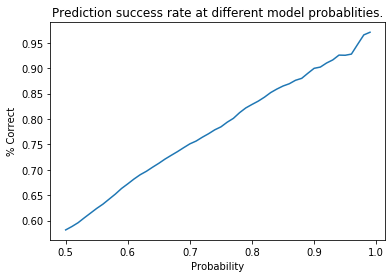

In [20]:
def buy_signal_curve():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.prediction_correct == True)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(correct / total)
    plt.plot(odds, curve)
    plt.title('Prediction success rate at different model probablities.')
    plt.xlabel('Probability')
    plt.ylabel('% Correct')
    
buy_signal_curve()

Not so fast. If you plot the number of test predictions by success rate, the number of predictions beyond 50% confidence drops dramatically. 

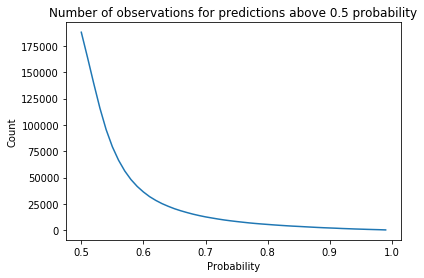

In [28]:
def buy_signal_curve_2():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.signal == 1)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(total)
    plt.plot(odds, curve)
    plt.title('Number of observations for predictions above 0.5 probability')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    
buy_signal_curve_2()

A histogram of probability counts shows how narrow the distribution actually is.

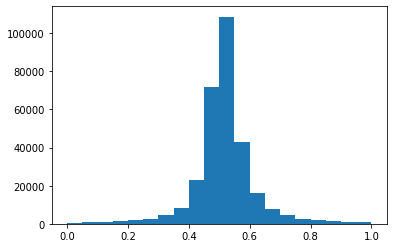

In [34]:
_ = plt.hist(predictions.prediction, bins=20)

Finally, I plot various model metrics, such as the ROC AUC. Both the AUC score and the F1 score beat the base XGBoost model.

In [25]:
def plot_classifier(model, X_train, y_train, X_test, y_test):    
    
    y_pred_train = model.predict(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred_test = model.predict(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
    plt.plot(fpr_train, tpr_train, label='Training Data')
    plt.plot(fpr, tpr, label='Testing Data')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='upper left')
    plt.show()
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}, Train F1 Score: {f1_score(y_train, y_pred_train.round())}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}, Test F1 Score: {f1_score(y_test, y_pred_test.round())}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test.round())}')

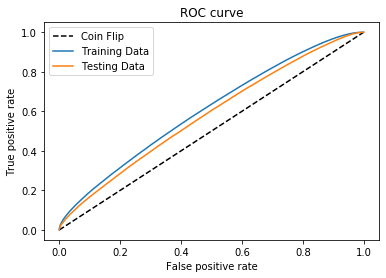

Train AUC: 0.60575124329126, Train F1 Score: 0.6114704454935244
Test AUC: 0.5805015516055859, Test F1 Score: 0.6208455054664588
Test Accuracy: 0.5604712774185056


In [26]:
plot_classifier(best_model, X_train_scaled, y_train, X_test_scaled, y_test)